### Second solution

For the second solution I'm using tokenizer for word embedding. I'm also going to use LSTM.

I've commented all lines of code that may take a lot of time in order to avoid rewriting weights.  
Uncomment if needed

In [ ]:
from __future__ import print_function

import pandas as pd

from gensim.corpora.dictionary import Dictionary

from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM, GlobalAveragePooling1D, SpatialDropout1D
from keras.datasets import imdb
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [106]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [63]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [64]:
texts = list(train_df['text'])
texts.extend(test_df['text'])
len(texts)

4649

In [65]:
def yes_no_int(text):
    if text == "Yes":
        return 1
    else:
        return 0

In [66]:
train_df['labels'] = train_df['labels'].apply(yes_no_int)
test_df['labels'] = test_df['labels'].apply(yes_no_int)

In [67]:
texts = list(train_df['text'])
texts.extend(test_df['text'])
len(texts)

4649

In [68]:
train_df[train_df['labels']==1].count()

text      1719
labels    1719
dtype: int64

In [69]:
test_df['labels'].unique()

array([0, 1])

In [70]:
labels = list(train_df['labels'])
labels.extend(test_df['labels'])
len(labels)

4649

In [117]:
tokenizer = Tokenizer(num_words=6000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [118]:
tokenizer.fit_on_texts(texts)

In [119]:
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=216)

In [120]:
X.shape

(4649, 216)

In [121]:
vocab_size = len(tokenizer.word_index)

In [122]:
vocab_size

6876

In [123]:
x_train = tokenizer.texts_to_sequences(train_df['text'].values)
x_train = pad_sequences(x_train, maxlen=216, truncating='post')

In [124]:
x_test = tokenizer.texts_to_sequences(test_df['text'].values)
x_test = pad_sequences(x_test, maxlen=216, truncating='post')

In [125]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 train_df['labels'].unique(),
                                                 train_df['labels'])
print(class_weights)

[0.94349845 1.06369983]


In [126]:
x_test.shape

(992, 216)

In [127]:
x_train.shape

(3657, 216)

### Try 1
LSTM

LSTM may be useful because the use of contextual information and past experience of the network’s input is important while working with text.

In [133]:
model = Sequential()
model.add(Embedding(6000, 128, input_length=x_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [134]:
# checkpointer1 = ModelCheckpoint(filepath="weights1.hdf5", verbose=1, save_best_only=True)
# history = model.fit(x_train, train_df['labels'],
#           class_weight=class_weights,
#           batch_size=512,
#           epochs=10,
#           validation_data=(x_test, test_df['labels']),
#           callbacks=[checkpointer1])

Train on 3657 samples, validate on 992 samples
Epoch 1/10
3657/3657 [==============================] - 17s 5ms/step - loss: 0.6913 - acc: 0.5332 - val_loss: 0.6790 - val_acc: 0.6956

Epoch 00001: val_loss improved from inf to 0.67902, saving model to weights1.hdf5
Epoch 2/10
3657/3657 [==============================] - 15s 4ms/step - loss: 0.6817 - acc: 0.5600 - val_loss: 0.6615 - val_acc: 0.7419

Epoch 00002: val_loss improved from 0.67902 to 0.66147, saving model to weights1.hdf5
Epoch 3/10
3657/3657 [==============================] - 15s 4ms/step - loss: 0.6580 - acc: 0.6806 - val_loss: 0.6151 - val_acc: 0.7631

Epoch 00003: val_loss improved from 0.66147 to 0.61512, saving model to weights1.hdf5
Epoch 4/10
3657/3657 [==============================] - 14s 4ms/step - loss: 0.6016 - acc: 0.7364 - val_loss: 0.5891 - val_acc: 0.6946

Epoch 00004: val_loss improved from 0.61512 to 0.58906, saving model to weights1.hdf5
Epoch 5/10
3657/3657 [==============================] - 15s 4ms/step 

In [135]:
model.load_weights("weights1.hdf5")

In [136]:
score, acc = model.evaluate(x_test, test_df['labels'], batch_size=512)
print('Test loss:', score)
print('Test accuracy:', acc)

992/992 [==============================] - 1s 1ms/step
Test loss: 0.45498659918385165
Test accuracy: 0.7792338786586639


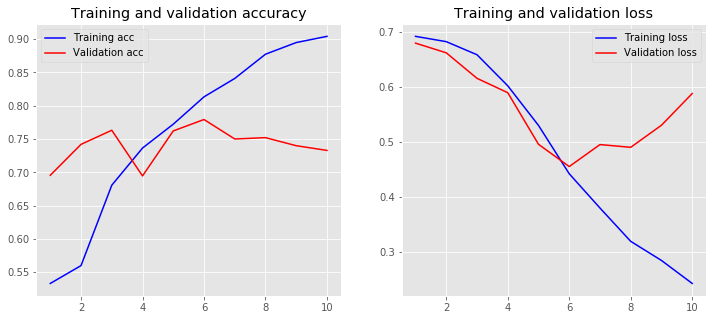

In [137]:
plot_history(history)

LSTM shows worse results in comparison with the first solution. Let's try something else.

### try 2

Using max pooling

Here I'm proposing that using max pooling may be a good idea. Features exctracted from tokenized data after demensionality reduction are more general and may lead to better score.

In [49]:
from keras.layers import Flatten, GlobalMaxPool1D

In [108]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=x_train.shape[1]))
model.add(GlobalMaxPool1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [109]:
# checkpointer1 = ModelCheckpoint(filepath="weights2.hdf5", verbose=1, save_best_only=True)
# history = model.fit(x_train, train_df['labels'],
#           class_weight=class_weights,
#           batch_size=128,
#           epochs=10,
#           validation_data=(x_test, test_df['labels']),
#           callbacks=[checkpointer1])

Train on 3657 samples, validate on 992 samples
Epoch 1/10
3657/3657 [==============================] - 6s 2ms/step - loss: 0.6861 - acc: 0.5458 - val_loss: 0.6698 - val_acc: 0.8407

Epoch 00001: val_loss improved from inf to 0.66978, saving model to weights2.hdf5
Epoch 2/10
3657/3657 [==============================] - 6s 2ms/step - loss: 0.6315 - acc: 0.7342 - val_loss: 0.5491 - val_acc: 0.8357

Epoch 00002: val_loss improved from 0.66978 to 0.54912, saving model to weights2.hdf5
Epoch 3/10
3657/3657 [==============================] - 5s 1ms/step - loss: 0.4572 - acc: 0.8250 - val_loss: 0.4220 - val_acc: 0.8196

Epoch 00003: val_loss improved from 0.54912 to 0.42196, saving model to weights2.hdf5
Epoch 4/10
3657/3657 [==============================] - 5s 1ms/step - loss: 0.2960 - acc: 0.8903 - val_loss: 0.4268 - val_acc: 0.7903

Epoch 00004: val_loss did not improve from 0.42196
Epoch 5/10
3657/3657 [==============================] - 5s 1ms/step - loss: 0.1932 - acc: 0.9319 - val_loss:

In [110]:
model.load_weights("weights2.hdf5")

In [111]:
score, acc = model.evaluate(x_test, test_df['labels'], batch_size=512)
print('Test loss:', score)
print('Test accuracy:', acc)

992/992 [==============================] - 0s 35us/step
Test loss: 0.4219647905518932
Test accuracy: 0.8195564400765204


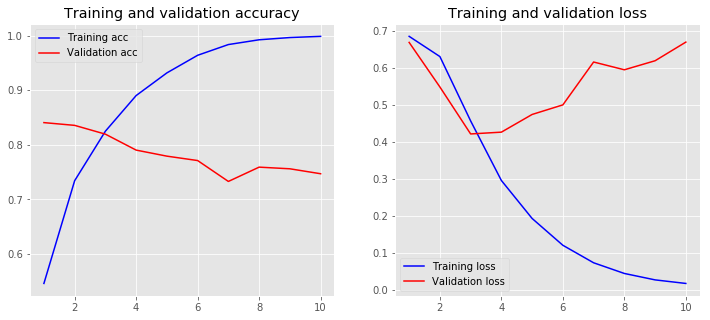

In [112]:
plot_history(history)

The score of my second solution is 81.9%